In [3]:
!pip install s3fs

In [4]:
import json

from matplotlib import pyplot as plt
import pandas as pd
import pickle
from s3fs.core import S3FileSystem

In [5]:
MODEL_DIR = "mids-capstone-irrigation-detection/models"

In [51]:
s3_file = S3FileSystem()

# Models are model_name: description
models = {
    "simclr_finetune": "Fine tuned on 3% data",
    "simclr_finetune_ex": "Fine tuned on 3% data with Extended Labels",
}

In [7]:
def f_scores(scores):
    precision = scores[6]
    recall = scores[7]
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    

In [78]:
def load_results():
    data = []
    for file in s3_file.listdir(MODEL_DIR):
        if file['type'] != 'directory':
            continue
        model_type = file["name"].split("/")[-1]
        if not model_type.startswith("simclr"):
            continue
        for result in s3_file.glob(file["name"]+"/*.json"):
            model_type = result.split("/")[-2]
            percent = result.split("/")[-1].split("_")[0]
            augmentations = result.split("/")[-1].split("_")[-1].split(".")[0]
            r = json.load(s3_file.open(result))
            score = [model_type, int(percent), augmentations] + r["score"] + f_scores(r["score"])
            data.append(score)
    df = pd.DataFrame(data)
    df.columns = ["model_type","split_percent","augmentations","loss","tp","fp","tn","fn","accuracy","precision","recall","auc","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df

def plot_results(plot_df, title=None):
    _title = "Augmentations vs F1 Score"
    if title is not None:
        _title += f" - {title}"
    plot_df = plot_df.sort_values("f1")
    plot_df.plot(kind="barh", figsize=(15,12), rot=0, ylim=(0.0, 1.0), fontsize=12, x='augmentations', y='f1')
    
    plt.title(_title, fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Augmentations", fontsize=18)

def display_results(df = None):
    if df is None:
        df = load_results()
    for model_type, desc in models.items():
        _df = df[df.model_type == model_type]
        
        line = "=" * len(desc) + "=="
        print(f"\n\n{line}\n {desc}\n{line}")
        display(_df.sort_values("split_percent"))

        plot_results(_df, desc)
        plt.savefig(f"{model_type}.png")



 Fine tuned on 3% data


,model_type,split_percent,augmentations,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
0,simclr_finetune,3,"blur,brightness",0.634854,1363.0,512.0,1522.0,667.0,0.709892,0.726933,0.671429,0.795867,0.698079,0.707439
20,simclr_finetune,3,"shift,contrast",0.657598,1482.0,305.0,1725.0,552.0,0.789124,0.829323,0.728614,0.876310,0.775713,0.792796
21,simclr_finetune,3,"shift,flip",0.621533,1489.0,359.0,1675.0,541.0,0.778543,0.805736,0.733498,0.865170,0.767922,0.780126
22,simclr_finetune,3,"shift,gain",0.977125,1716.0,643.0,1389.0,316.0,0.764026,0.727427,0.844488,0.831317,0.781599,0.762667
23,simclr_finetune,3,"shift,zoom",0.747490,1652.0,528.0,1504.0,380.0,0.776575,0.757798,0.812992,0.855551,0.784425,0.775344
24,simclr_finetune,3,"speckle,blur",0.508529,1673.0,487.0,1546.0,358.0,0.792077,0.774537,0.823732,0.875605,0.798377,0.790269
25,simclr_finetune,3,"speckle,brightness",1.013925,1572.0,466.0,1566.0,460.0,0.772146,0.771344,0.773622,0.846040,0.772482,0.772102
19,simclr_finetune,3,"shift,brightness",0.413802,1717.0,412.0,1616.0,319.0,0.820128,0.806482,0.843320,0.897567,0.824490,0.818398
26,simclr_finetune,3,"speckle,contrast",0.531671,1651.0,420.0,1613.0,380.0,0.803150,0.797199,0.812900,0.882906,0.804973,0.802365
28,simclr_finetune,3,"speckle,gain",0.452120,1740.0,529.0,1504.0,291.0,0.798228,0.766858,0.856721,0.873305,0.809302,0.794641




 Fine tuned on 3% data with Extended Labels


,model_type,split_percent,augmentations,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
36,simclr_finetune_ex,3,"blur,brightness",0.583239,4254.0,1203.0,4287.0,1232.0,0.778152,0.779549,0.775428,0.845406,0.777483,0.778171
56,simclr_finetune_ex,3,"shift,contrast",0.450034,4648.0,1326.0,4163.0,839.0,0.802751,0.778038,0.847093,0.876756,0.811098,0.799771
57,simclr_finetune_ex,3,"shift,flip",0.459547,4139.0,1034.0,4454.0,1349.0,0.782890,0.800116,0.754191,0.866140,0.776475,0.784199
58,simclr_finetune_ex,3,"shift,gain",0.526358,4446.0,1284.0,4200.0,1046.0,0.787719,0.775916,0.809541,0.861212,0.792372,0.786810
59,simclr_finetune_ex,3,"shift,zoom",0.450377,4766.0,1446.0,4043.0,721.0,0.802569,0.767225,0.868599,0.870696,0.814771,0.798280
60,simclr_finetune_ex,3,"speckle,blur",0.465096,4192.0,1087.0,4404.0,1293.0,0.783163,0.794090,0.764266,0.865914,0.778893,0.783893
61,simclr_finetune_ex,3,"speckle,brightness",0.467478,4469.0,1267.0,4220.0,1020.0,0.791636,0.779114,0.814174,0.858788,0.796258,0.790460
55,simclr_finetune_ex,3,"shift,brightness",0.454473,4305.0,1105.0,4377.0,1189.0,0.790999,0.795749,0.783582,0.871663,0.789618,0.791651
62,simclr_finetune_ex,3,"speckle,contrast",0.472909,4109.0,1000.0,4486.0,1381.0,0.783072,0.804267,0.748452,0.866048,0.775356,0.784759
64,simclr_finetune_ex,3,"speckle,gain",0.459885,4569.0,1308.0,4184.0,915.0,0.797467,0.777437,0.833151,0.877457,0.804331,0.795162


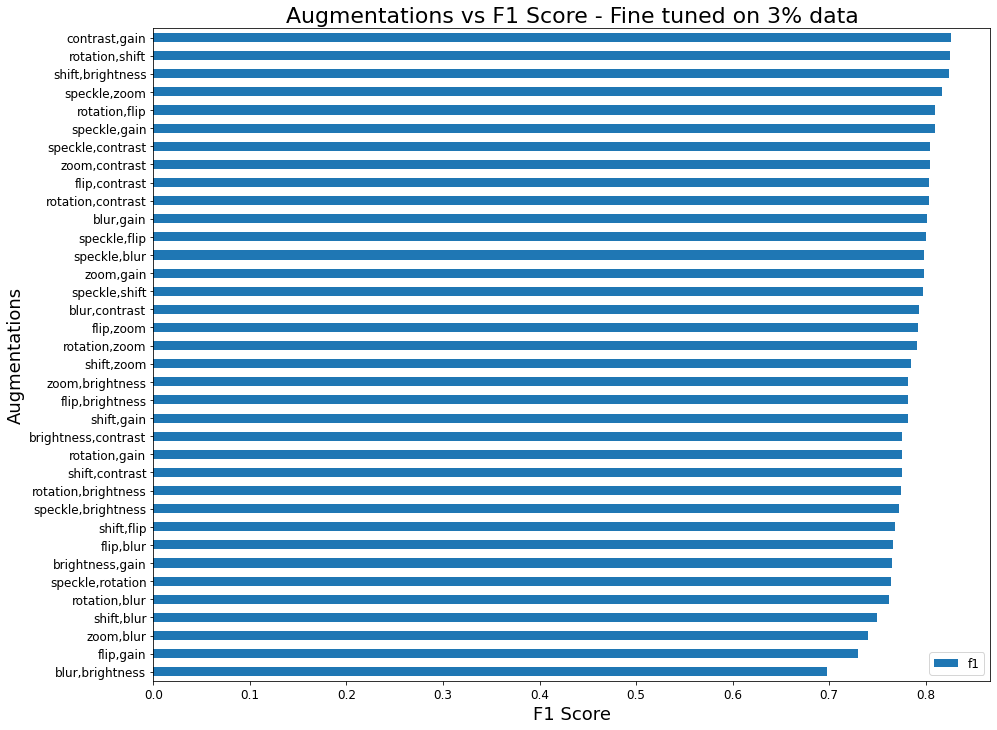

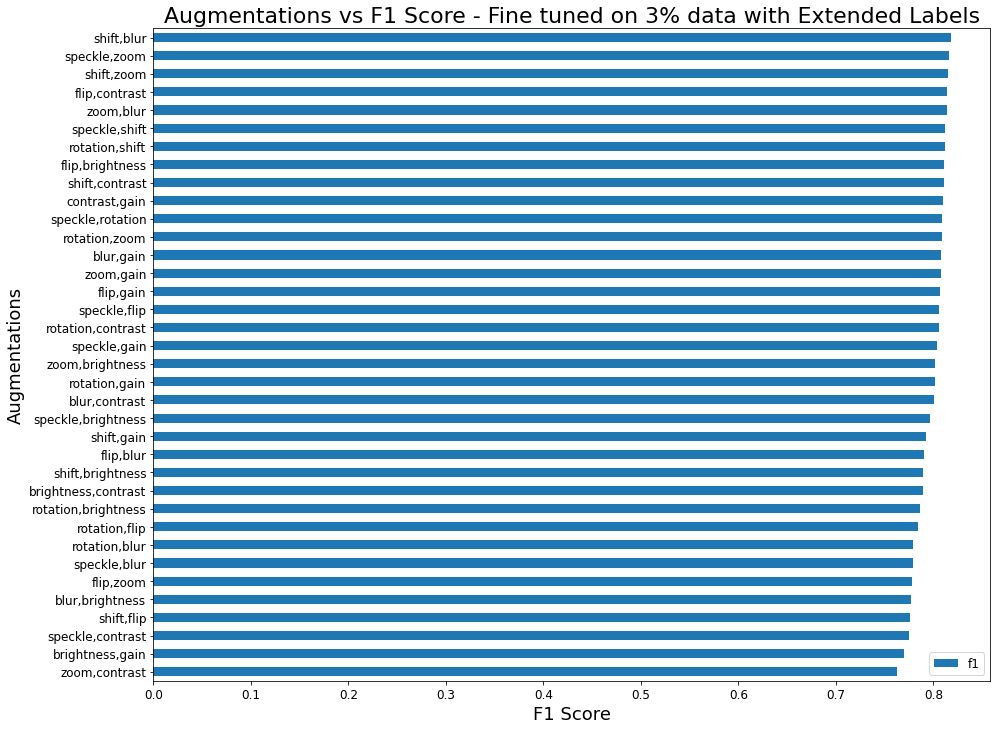

In [79]:
display_results(df)

In [58]:
df = load_results()

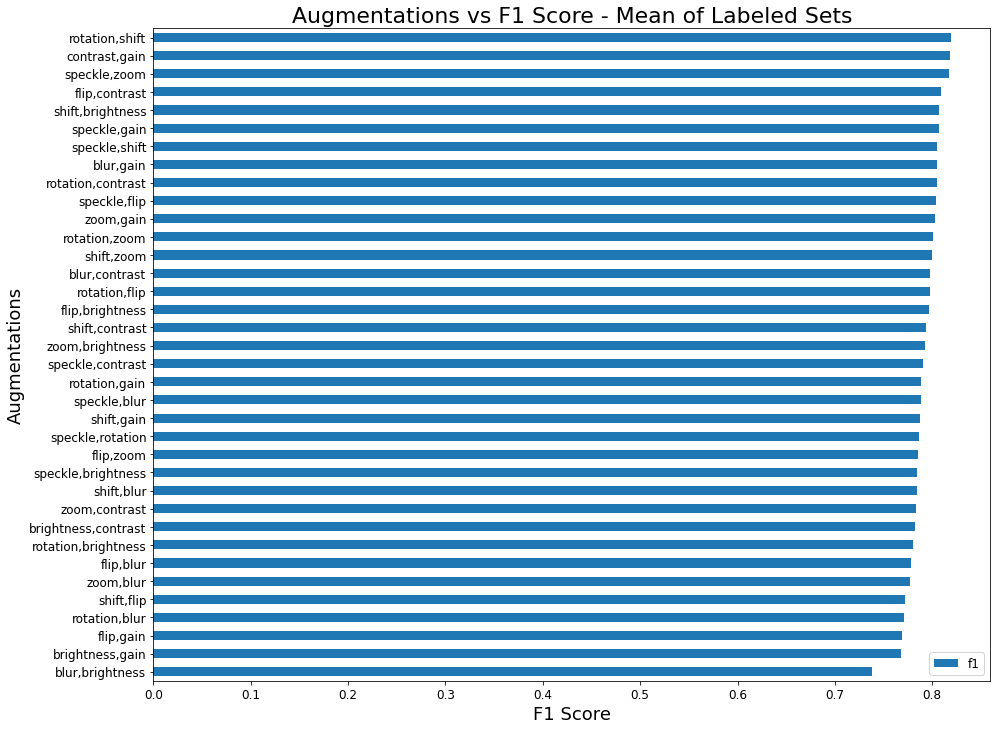

In [77]:
def plot_mean():
    mean_df = df[["augmentations", "f1"]].groupby(['augmentations']).mean().sort_values("f1")
    mean_df.plot(kind="barh", figsize=(15,12), rot=0, ylim=(0.0, 1.0), fontsize=12)
    plt.title("Augmentations vs F1 Score - Mean of Labeled Sets", fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Augmentations", fontsize=18)
plot_mean()

In [68]:
mean_df

,f1
augmentations,
"blur,brightness",0.737781
"blur,contrast",0.797280
"blur,gain",0.804524
"brightness,contrast",0.782587
"brightness,gain",0.767782
"contrast,gain",0.818061
"flip,blur",0.778650
"flip,brightness",0.796536
"flip,contrast",0.808976


In [81]:
df.to_csv("results.csv")